# Imports and configs

In [1]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from autogluon.tabular import TabularPredictor
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
import pickle
import shutil
import os

warnings.filterwarnings('ignore')

In [2]:
class CFG:
    train_path = '/kaggle/input/playground-series-s5e3/train.csv'
    test_path = '/kaggle/input/playground-series-s5e3/test.csv'
    sample_sub_path = '/kaggle/input/playground-series-s5e3/sample_submission.csv'
    
    original_path = "/kaggle/input/hongkongrainfall/hongkong.csv"
    original_path_2 = "/kaggle/input/rainfall-prediction-using-machine-learning/Rainfall.csv"
    
    target = 'rainfall'
    n_folds = 10
    seed = 2100
    time_limit = 3600 * 6

# Loading data and predefining folds

In [3]:
train = pd.read_csv(CFG.train_path, index_col="id")
test = pd.read_csv(CFG.test_path, index_col="id")

original = pd.read_csv(CFG.original_path, encoding="gbk")
original["date"] = pd.to_datetime(original[["year", "month", "day"]])
original = original.drop(["year", "month", "day", "low visibility hour", "radiation", "evaporation"], axis=1)
original["day"] = original.date.dt.dayofyear
original = original.drop("date", axis=1)
original.rainfall = original.rainfall.apply(lambda x: 1 if str(x).replace('.', '', 1).isdigit() else x)
original.rainfall = original.rainfall.replace({'微量': 1, '-': 0}).astype(int)
original.sunshine = original.sunshine.replace('-', 0).astype(float)
for col in original.columns:
    original[col] = original[col].astype(train[col].dtype)
    
original_2 = pd.read_csv(CFG.original_path_2)
original_2.columns = original_2.columns.str.replace(" ", "")
original_2[CFG.target] = original_2[CFG.target].map({"yes": 1, "no": 0})
original_2.day = original_2.index + 1
for col in original_2.columns:
    original_2[col] = original_2[col].astype(train[col].dtype)
    
original_combined = pd.concat([original, original_2], axis=0).reset_index(drop=True)
original_combined = original_combined.drop_duplicates().reset_index(drop=True)

In [4]:
skf = StratifiedKFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True)
split = skf.split(train, train[CFG.target])
for i, (_, val_index) in enumerate(split):
    train.loc[val_index, 'fold'] = i

# Fitting the predictor

In [5]:
predictor = TabularPredictor(
    path='/AutoGluonModels',
    problem_type='binary',
    eval_metric='roc_auc',
    label=CFG.target,
    groups='fold',
    verbosity=2
)

In [6]:
predictor.fit_pseudolabel(
    pseudo_data=original_combined,
    train_data=train,
    time_limit=CFG.time_limit,
    presets='experimental_quality'
)

Predictor not fit prior to pseudolabeling. Fitting now...
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Nov 10 10:07:59 UTC 2024
CPU Count:          4
Memory Avail:       30.31 GB / 31.35 GB (96.7%)
Disk Space Avail:   1892.13 GB / 8062.39 GB (23.5%)
Presets specified: ['experimental_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subset

(_ray_fit pid=7666) [1000]	valid_set's binary_logloss: 0.300476
(_ray_fit pid=7793) [1000]	valid_set's binary_logloss: 0.346226 [repeated 8x across cluster]
(_ray_fit pid=7922) [1000]	valid_set's binary_logloss: 0.320026 [repeated 2x across cluster]


(_dystack pid=162) 	0.8987	 = Validation score   (roc_auc)
(_dystack pid=162) 	14.71s	 = Training   runtime
(_dystack pid=162) 	0.23s	 = Validation runtime
(_dystack pid=162) Fitting model: NeuralNetTorch_r22_BAG_L1 ... Training model for up to 617.74s of the 2417.15s of remaining time.
(_dystack pid=162) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)
(_dystack pid=162) 	0.8961	 = Validation score   (roc_auc)
(_dystack pid=162) 	40.59s	 = Training   runtime
(_dystack pid=162) 	0.16s	 = Validation runtime
(_dystack pid=162) Fitting model: XGBoost_r33_BAG_L1 ... Training model for up to 573.96s of the 2373.37s of remaining time.
(_dystack pid=162) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.12%)
(_dystack pid=162) 	0.8885	 = Validation score   (roc_auc)
(_dystack pid=162) 	13.76s	 = Training   runtime
(_dystack pid=1

(autoscaler +51m3s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.
(autoscaler +51m3s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=162) 	0.8974	 = Validation score   (roc_auc)
(_dystack pid=162) 	14.47s	 = Training   runtime
(_dystack pid=162) 	0.03s	 = Validation runtime
(_dystack pid=162) Fitting model: NeuralNetFastAI_r102_BAG_L1 ... Training model for up to 521.58s of the 2320.99s of remaining time.
(_dystack pid=162) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +51m38s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=9529) No improvement since epoch 2: early stopping


(autoscaler +52m13s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=9894) No improvement since epoch 2: early stopping [repeated 2x across cluster]
(_dystack pid=162) 	0.9023	 = Validation score   (roc_auc)
(_dystack pid=162) 	75.94s	 = Training   runtime
(_dystack pid=162) 	0.42s	 = Validation runtime
(_dystack pid=162) Fitting model: CatBoost_r13_BAG_L1 ... Training model for up to 442.20s of the 2241.61s of remaining time.
(_dystack pid=162) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.06%)


(autoscaler +52m48s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=162) 	0.8977	 = Validation score   (roc_auc)
(_dystack pid=162) 	33.83s	 = Training   runtime
(_dystack pid=162) 	0.03s	 = Validation runtime
(_dystack pid=162) Fitting model: RandomForest_r195_BAG_L1 ... Training model for up to 404.56s of the 2203.97s of remaining time.
(_dystack pid=162) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=162) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +53m23s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=162) 	0.8804	 = Validation score   (roc_auc)
(_dystack pid=162) 	21.05s	 = Training   runtime
(_dystack pid=162) 	1.04s	 = Validation runtime
(_dystack pid=162) Fitting model: LightGBM_r188_BAG_L1 ... Training model for up to 380.04s of the 2179.44s of remaining time.
(_dystack pid=162) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.03%)
(_dystack pid=162) 	0.895	 = Validation score   (roc_auc)
(_dystack pid=162) 	15.01s	 = Training   runtime
(_dystack pid=162) 	0.05s	 = Validation runtime
(_dystack pid=162) Fitting model: NeuralNetFastAI_r145_BAG_L1 ... Training model for up to 361.42s of the 2160.83s of remaining time.
(_dystack pid=162) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +54m3s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=11167) No improvement since epoch 9: early stopping
(_ray_fit pid=11346) No improvement since epoch 7: early stopping
(_ray_fit pid=11380) No improvement since epoch 9: early stopping
(_dystack pid=162) 	0.8913	 = Validation score   (roc_auc)
(_dystack pid=162) 	44.27s	 = Training   runtime
(_dystack pid=162) 	0.32s	 = Validation runtime
(_dystack pid=162) Fitting model: XGBoost_r89_BAG_L1 ... Training model for up to 313.60s of the 2113.01s of remaining time.
(_dystack pid=162) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +54m53s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=162) 	0.8967	 = Validation score   (roc_auc)
(_dystack pid=162) 	9.66s	 = Training   runtime
(_dystack pid=162) 	0.07s	 = Validation runtime
(_dystack pid=162) Fitting model: NeuralNetTorch_r30_BAG_L1 ... Training model for up to 299.60s of the 2099.01s of remaining time.
(_dystack pid=162) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +55m28s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(autoscaler +56m4s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=162) 	0.8945	 = Validation score   (roc_auc)
(_dystack pid=162) 	78.07s	 = Training   runtime
(_dystack pid=162) 	0.14s	 = Validation runtime
(_dystack pid=162) Fitting model: LightGBM_r130_BAG_L1 ... Training model for up to 218.01s of the 2017.42s of remaining time.
(_dystack pid=162) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)
(_dystack pid=162) 	0.8945	 = Validation score   (roc_auc)
(_dystack pid=162) 	14.6s	 = Training   runtime
(_dystack pid=162) 	0.04s	 = Validation runtime
(_dystack pid=162) Fitting model: NeuralNetTorch_r86_BAG_L1 ... Training model for up to 199.87s of the 1999.28s of remaining time.
(_dystack pid=162) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +56m44s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=162) 	0.8913	 = Validation score   (roc_auc)
(_dystack pid=162) 	39.13s	 = Training   runtime
(_dystack pid=162) 	0.14s	 = Validation runtime
(_dystack pid=162) Fitting model: CatBoost_r50_BAG_L1 ... Training model for up to 157.14s of the 1956.55s of remaining time.
(_dystack pid=162) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +57m29s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=162) 	0.9004	 = Validation score   (roc_auc)
(_dystack pid=162) 	16.16s	 = Training   runtime
(_dystack pid=162) 	0.04s	 = Validation runtime
(_dystack pid=162) Fitting model: NeuralNetFastAI_r11_BAG_L1 ... Training model for up to 137.63s of the 1937.04s of remaining time.
(_dystack pid=162) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)
(_ray_fit pid=13372) No improvement since epoch 6: early stopping


(autoscaler +58m4s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=13585) No improvement since epoch 8: early stopping
(_ray_fit pid=13736) No improvement since epoch 9: early stopping
(_dystack pid=162) 	0.8962	 = Validation score   (roc_auc)
(_dystack pid=162) 	53.23s	 = Training   runtime
(_dystack pid=162) 	0.33s	 = Validation runtime
(_dystack pid=162) Fitting model: XGBoost_r194_BAG_L1 ... Training model for up to 80.84s of the 1880.25s of remaining time.
(_dystack pid=162) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.03%)


(autoscaler +58m44s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=162) 	0.8865	 = Validation score   (roc_auc)
(_dystack pid=162) 	10.36s	 = Training   runtime
(_dystack pid=162) 	0.06s	 = Validation runtime
(_dystack pid=162) Fitting model: ExtraTrees_r172_BAG_L1 ... Training model for up to 66.51s of the 1865.92s of remaining time.
(_dystack pid=162) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=162) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)
(_dystack pid=162) 	0.891	 = Validation score   (roc_auc)
(_dystack pid=162) 	13.12s	 = Training   runtime
(_dystack pid=162) 	0.85s	 = Validation runtime
(_dystack pid=162) Fitting model: CatBoost_r69_BAG_L1 ... Training model for up to 49.81s of the 1849.22s of remaining time.
(_dystack pid=162) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +59m19s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=162) 	0.8987	 = Validation score   (roc_auc)
(_dystack pid=162) 	14.66s	 = Training   runtime
(_dystack pid=162) 	0.02s	 = Validation runtime
(_dystack pid=162) Fitting model: NeuralNetFastAI_r103_BAG_L1 ... Training model for up to 31.43s of the 1830.84s of remaining time.
(_dystack pid=162) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)
(_ray_fit pid=15009) No improvement since epoch 16: early stopping


(autoscaler +59m54s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=15223) No improvement since epoch 14: early stopping [repeated 3x across cluster]
(_ray_fit pid=15373) No improvement since epoch 20: early stopping [repeated 4x across cluster]
(_dystack pid=162) 	0.8961	 = Validation score   (roc_auc)
(_dystack pid=162) 	37.02s	 = Training   runtime
(_dystack pid=162) 	0.16s	 = Validation runtime
(_dystack pid=162) Fitting model: WeightedEnsemble_L2 ... Training model for up to 360.00s of the 1790.24s of remaining time.
(_dystack pid=162) 	Ensemble Weights: {'NeuralNetFastAI_r102_BAG_L1': 0.44, 'CatBoost_r50_BAG_L1': 0.32, 'NeuralNetTorch_r22_BAG_L1': 0.08, 'NeuralNetTorch_r30_BAG_L1': 0.08, 'KNeighborsDist_BAG_L1': 0.04, 'XGBoost_r89_BAG_L1': 0.04}
(_dystack pid=162) 	0.907	 = Validation score   (roc_auc)
(_dystack pid=162) 	0.31s	 = Training   runtime
(_dystack pid=162) 	0.0s	 = Validation runtime
(_dystack pid=162) Fitting 109 L2 models, fit_strategy="parallel" ...
(_dystack pid=162) Note: fit_strategy='parallel', but `num_cpus=4`. R

(autoscaler +1h34s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=162) 	0.8962	 = Validation score   (roc_auc)
(_dystack pid=162) 	15.92s	 = Training   runtime
(_dystack pid=162) 	0.04s	 = Validation runtime
(_dystack pid=162) Fitting model: RandomForestGini_BAG_L2 ... Training model for up to 1752.04s of the 1751.86s of remaining time.
(_dystack pid=162) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=162) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)
(_dystack pid=162) 	0.8998	 = Validation score   (roc_auc)
(_dystack pid=162) 	16.76s	 = Training   runtime
(_dystack pid=162) 	0.94s	 = Validation runtime
(_dystack pid=162) Fitting model: RandomForestEntr_BAG_L2 ... Training model for up to 1731.48s of the 1731.30s of remaining time.
(_dystack pid=162) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=162) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 wo

(autoscaler +1h1m14s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=162) 	0.9022	 = Validation score   (roc_auc)
(_dystack pid=162) 	18.37s	 = Training   runtime
(_dystack pid=162) 	0.96s	 = Validation runtime
(_dystack pid=162) Fitting model: CatBoost_BAG_L2 ... Training model for up to 1709.49s of the 1709.31s of remaining time.
(_dystack pid=162) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.07%)


(autoscaler +1h1m49s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=162) 	0.9033	 = Validation score   (roc_auc)
(_dystack pid=162) 	23.6s	 = Training   runtime
(_dystack pid=162) 	0.05s	 = Validation runtime
(_dystack pid=162) Fitting model: ExtraTreesGini_BAG_L2 ... Training model for up to 1682.55s of the 1682.38s of remaining time.
(_dystack pid=162) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=162) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)
(_dystack pid=162) 	0.9036	 = Validation score   (roc_auc)
(_dystack pid=162) 	12.88s	 = Training   runtime
(_dystack pid=162) 	1.06s	 = Validation runtime
(_dystack pid=162) Fitting model: ExtraTreesEntr_BAG_L2 ... Training model for up to 1666.08s of the 1665.90s of remaining time.
(_dystack pid=162) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=162) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers

(autoscaler +1h2m24s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=162) 	0.9012	 = Validation score   (roc_auc)
(_dystack pid=162) 	13.52s	 = Training   runtime
(_dystack pid=162) 	0.99s	 = Validation runtime
(_dystack pid=162) Fitting model: NeuralNetFastAI_BAG_L2 ... Training model for up to 1648.91s of the 1648.73s of remaining time.
(_dystack pid=162) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +1h3m0s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=162) 	0.9059	 = Validation score   (roc_auc)
(_dystack pid=162) 	32.87s	 = Training   runtime
(_dystack pid=162) 	0.26s	 = Validation runtime
(_dystack pid=162) Fitting model: TabPFNMix_v1_BAG_L2 ... Training model for up to 1612.56s of the 1612.38s of remaining time.
(_dystack pid=162) 	Memory not enough to fit 10 folds in parallel. Will train 2 folds in parallel instead (Estimated 28.27% memory usage per fold, 56.54%/80.00% total).
(_dystack pid=162) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (2 workers, per: cpus=2, gpus=0, memory=28.27%)


(autoscaler +1h3m10s) Warning: The following resource request cannot be scheduled right now: {'CPU': 2.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(autoscaler +1h3m45s) Warning: The following resource request cannot be scheduled right now: {'CPU': 2.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(autoscaler +1h4m20s) Warning: The following resource request cannot be scheduled right now: {'CPU': 2.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(autoscaler +1h4m55s) Warning: The following resource request cannot be scheduled right now: {'CPU': 2.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(aut

(_dystack pid=162) 	0.9045	 = Validation score   (roc_auc)
(_dystack pid=162) 	1273.26s	 = Training   runtime
(_dystack pid=162) 	50.05s	 = Validation runtime
(_dystack pid=162) Fitting model: XGBoost_BAG_L2 ... Training model for up to 333.51s of the 333.33s of remaining time.
(_dystack pid=162) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.08%)


(autoscaler +1h24m33s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=162) 	0.8973	 = Validation score   (roc_auc)
(_dystack pid=162) 	12.55s	 = Training   runtime
(_dystack pid=162) 	0.1s	 = Validation runtime
(_dystack pid=162) Fitting model: NeuralNetTorch_BAG_L2 ... Training model for up to 317.40s of the 317.22s of remaining time.
(_dystack pid=162) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +1h25m8s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=162) 	0.9018	 = Validation score   (roc_auc)
(_dystack pid=162) 	39.51s	 = Training   runtime
(_dystack pid=162) 	0.34s	 = Validation runtime
(_dystack pid=162) Fitting model: LightGBMLarge_BAG_L2 ... Training model for up to 274.58s of the 274.40s of remaining time.
(_dystack pid=162) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.13%)


(autoscaler +1h25m43s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=162) 	0.8793	 = Validation score   (roc_auc)
(_dystack pid=162) 	24.12s	 = Training   runtime
(_dystack pid=162) 	0.06s	 = Validation runtime
(_dystack pid=162) Fitting model: CatBoost_r177_BAG_L2 ... Training model for up to 246.99s of the 246.81s of remaining time.
(_dystack pid=162) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.07%)
(_dystack pid=162) 	0.9038	 = Validation score   (roc_auc)
(_dystack pid=162) 	22.5s	 = Training   runtime
(_dystack pid=162) 	0.05s	 = Validation runtime
(_dystack pid=162) Fitting model: NeuralNetTorch_r79_BAG_L2 ... Training model for up to 221.04s of the 220.86s of remaining time.
(_dystack pid=162) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +1h26m23s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=162) 	0.9046	 = Validation score   (roc_auc)
(_dystack pid=162) 	43.1s	 = Training   runtime
(_dystack pid=162) 	0.29s	 = Validation runtime
(_dystack pid=162) Fitting model: LightGBM_r131_BAG_L2 ... Training model for up to 174.56s of the 174.38s of remaining time.
(_dystack pid=162) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.06%)


(autoscaler +1h27m8s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=162) 	0.8981	 = Validation score   (roc_auc)
(_dystack pid=162) 	19.33s	 = Training   runtime
(_dystack pid=162) 	0.09s	 = Validation runtime
(_dystack pid=162) Fitting model: NeuralNetFastAI_r191_BAG_L2 ... Training model for up to 151.58s of the 151.40s of remaining time.
(_dystack pid=162) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +1h27m43s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=21280) No improvement since epoch 17: early stopping
(_ray_fit pid=21496) No improvement since epoch 6: early stopping [repeated 2x across cluster]
(_ray_fit pid=21644) No improvement since epoch 11: early stopping [repeated 2x across cluster]
(_dystack pid=162) 	0.8977	 = Validation score   (roc_auc)
(_dystack pid=162) 	45.67s	 = Training   runtime
(_dystack pid=162) 	0.21s	 = Validation runtime
(_dystack pid=162) Fitting model: CatBoost_r9_BAG_L2 ... Training model for up to 102.52s of the 102.34s of remaining time.
(_dystack pid=162) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.26%)


(autoscaler +1h28m23s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=21739) 	Ran out of time, early stopping on iteration 279.
(_ray_fit pid=21676) No improvement since epoch 10: early stopping


(autoscaler +1h28m58s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=21890) 	Ran out of time, early stopping on iteration 332. [repeated 4x across cluster]
(_dystack pid=162) 	0.907	 = Validation score   (roc_auc)
(_dystack pid=162) 	83.62s	 = Training   runtime
(_dystack pid=162) 	0.07s	 = Validation runtime
(_dystack pid=162) Fitting model: LightGBM_r96_BAG_L2 ... Training model for up to 15.46s of the 15.28s of remaining time.
(_dystack pid=162) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.03%)
(_ray_fit pid=21897) 	Ran out of time, early stopping on iteration 314. [repeated 3x across cluster]


(autoscaler +1h29m48s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(_ray_fit pid=22131) [1000]	valid_set's binary_logloss: 0.271964
(_ray_fit pid=22131) [2000]	valid_set's binary_logloss: 0.26776


(_ray_fit pid=22131) 	Ran out of time, early stopping on iteration 2969. Best iteration is:
(_ray_fit pid=22131) 	[2569]	valid_set's binary_logloss: 0.266033


(_ray_fit pid=22253) [2000]	valid_set's binary_logloss: 0.340206 [repeated 2x across cluster]


(_dystack pid=162) 	0.906	 = Validation score   (roc_auc)
(_dystack pid=162) 	16.13s	 = Training   runtime
(_dystack pid=162) 	0.23s	 = Validation runtime
(_dystack pid=162) Fitting model: WeightedEnsemble_L3 ... Training model for up to 360.00s of the -4.60s of remaining time.
(_dystack pid=162) 	Ensemble Weights: {'NeuralNetFastAI_BAG_L2': 0.364, 'CatBoost_r9_BAG_L2': 0.273, 'NeuralNetFastAI_r102_BAG_L1': 0.136, 'NeuralNetTorch_r79_BAG_L2': 0.136, 'NeuralNetTorch_BAG_L2': 0.045, 'CatBoost_r177_BAG_L2': 0.045}
(_dystack pid=162) 	0.9126	 = Validation score   (roc_auc)
(_dystack pid=162) 	0.24s	 = Training   runtime
(_dystack pid=162) 	0.0s	 = Validation runtime
(_dystack pid=162) AutoGluon training complete, total runtime = 5400.47s ... Best model: WeightedEnsemble_L3 | Estimated inference throughput: 3.4 rows/s (195 batch size)
(_dystack pid=162) TabularPredictor saved. To load, use: predictor = TabularPredictor.load("/AutoGluonModels/ds_sub_fit/sub_fit_ho")
(_dystack pid=162) INFO:s

In [7]:
def get_ensemble_weights(predictor):
    selected_models = []
    info = predictor.info()
    ensemble_weights = {}
    for model_name, values in info["model_info"].items():
        if "Ensemble" in model_name:
            children_info = values["children_info"]
            ensemble_weights[model_name] = values["children_info"][list(children_info.keys())[0]]["model_weights"]
            selected_models.extend(values["children_info"][list(children_info.keys())[0]]["model_weights"].keys())
            selected_models.append(model_name)
    return ensemble_weights, list(set(selected_models))

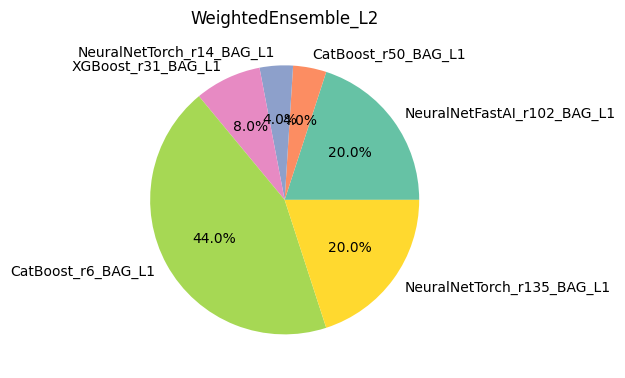

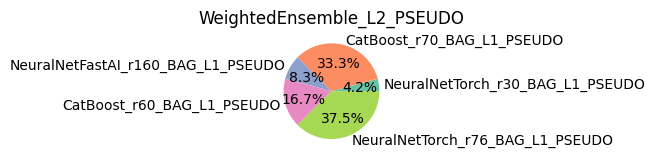

In [8]:
ensemble_weights, selected_models = get_ensemble_weights(predictor)

for key, value in ensemble_weights.items():
    plt.figure(figsize=(6, 6))
    plt.pie(value.values(), labels=value.keys(), autopct='%1.1f%%', colors=sns.color_palette('Set2', len(value)))
    plt.title(key)
    plt.tight_layout()
    plt.show()

In [9]:
predictor.leaderboard(silent=True)[predictor.leaderboard(silent=True).model.isin(selected_models)].style.background_gradient(subset=['score_val'], cmap='RdYlGn')

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2_PSEUDO,0.903459,roc_auc,0.637744,353.704002,0.000833,0.312051,2,True,207
1,WeightedEnsemble_L2,0.903180,roc_auc,0.943458,206.862690,0.000821,0.234436,2,True,112
2,CatBoost_r70_BAG_L1_PSEUDO,0.900259,roc_auc,0.031734,30.496820,0.031734,30.496820,1,True,155
3,CatBoost_r6_BAG_L1,0.899394,roc_auc,0.019036,14.701828,0.019036,14.701828,1,True,86
4,CatBoost_r60_BAG_L1_PSEUDO,0.899285,roc_auc,0.030517,18.758319,0.030517,18.758319,1,True,193
7,CatBoost_r50_BAG_L1,0.899127,roc_auc,0.022929,14.292370,0.022929,14.292370,1,True,34
8,NeuralNetTorch_r76_BAG_L1_PSEUDO,0.898953,roc_auc,0.135235,60.502836,0.135235,60.502836,1,True,203
26,NeuralNetTorch_r30_BAG_L1_PSEUDO,0.896823,roc_auc,0.159161,173.341183,0.159161,173.341183,1,True,143
30,NeuralNetFastAI_r160_BAG_L1_PSEUDO,0.896622,roc_auc,0.280264,70.292793,0.280264,70.292793,1,True,192
36,XGBoost_r31_BAG_L1,0.896473,roc_auc,0.217138,12.793630,0.217138,12.793630,1,True,78


# Collecting and saving OOF files

In [10]:
def save_pred_probs(pred_probs, cv_score, name, type, is_ensemble):
    base_path = 'oof_pred_probs' if type == 'oof' else 'test_pred_probs'
    base_path = '.' if is_ensemble else base_path
    with open(f'{base_path}/{name}_{type}_pred_probs_{cv_score:.6f}.pkl', 'wb') as f:
        pickle.dump(pred_probs, f)

def save_submission(test_pred_probs, score):
    sub = pd.read_csv(CFG.sample_sub_path)
    sub[CFG.target] = test_pred_probs
    sub.to_csv(f'sub_autogluon_{score:.6f}.csv', index=False)
    
os.makedirs('oof_pred_probs', exist_ok=True)
os.makedirs('test_pred_probs', exist_ok=True)

In [11]:
oof_pred_probs = {}
test_pred_probs = {}

In [12]:
overall_scores = {}
best_model = predictor.model_best
test_pred_probs = predictor.predict_proba_multi(test)
for model in predictor.model_names():
    model_oof_pred_probs = predictor.predict_proba_oof(model).values[:, 1]
    model_test_pred_probs = test_pred_probs[model].values[:, 1]
    
    cv_score = roc_auc_score(train[CFG.target], model_oof_pred_probs)
    overall_scores[model] = cv_score
    
    if model != best_model:
        save_pred_probs(model_oof_pred_probs, cv_score, model, 'oof', False)
        save_pred_probs(model_test_pred_probs, cv_score, model, 'test', False)
    else:
        save_pred_probs(model_oof_pred_probs, cv_score, model, 'oof', True)
        save_pred_probs(model_test_pred_probs, cv_score, model, 'test', True)
        save_submission(model_test_pred_probs, cv_score)
        
    oof_pred_probs[model] = model_oof_pred_probs
    test_pred_probs[model] = model_test_pred_probs

INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.

# Visualizing the results

In [13]:
scores = {}
split = StratifiedKFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True).split(train, train[CFG.target])
for fold_idx, (train_index, val_index) in enumerate(split):
    for model in predictor.model_names():
        fold_score = roc_auc_score(train.loc[val_index, CFG.target], oof_pred_probs[model][val_index])
        if model not in scores:
            scores[model] = []
        scores[model].append(fold_score)

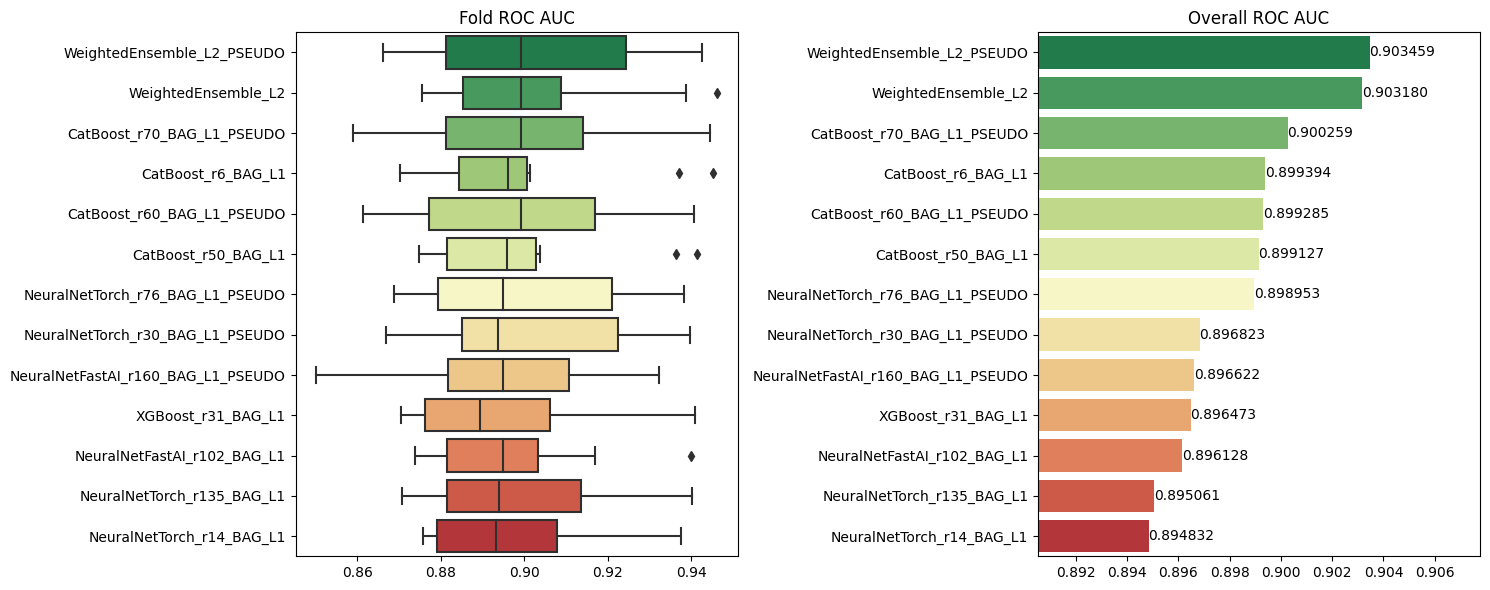

In [14]:
scores_df = pd.DataFrame(scores)[selected_models]
overall_scores_series = pd.Series({k: v for k, v in overall_scores.items()})[selected_models]
order = overall_scores_series.sort_values(ascending=False).index.tolist()

min_score = overall_scores_series.min()
max_score = overall_scores_series.max()
padding = (max_score - min_score) * 0.5
lower_limit = min_score - padding
upper_limit = max_score + padding

fig, axs = plt.subplots(1, 2, figsize=(15, len(scores_df) * 0.6))

sns.boxplot(data=scores_df, order=order, ax=axs[0], orient="h", palette="RdYlGn_r")
axs[0].set_title("Fold ROC AUC")
axs[0].set_xlabel("")
axs[0].set_ylabel("")

barplot = sns.barplot(x=overall_scores_series, y=overall_scores_series.index, ax=axs[1], palette="RdYlGn_r", order=order)
axs[1].set_title("Overall ROC AUC")
axs[1].set_xlabel("")
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel("")

for i, score in enumerate(overall_scores_series[order]):
    barplot.text(score, i, f"{score:.6f}", va="center")

plt.tight_layout()
plt.show()